# Reachability Analysis for Constrained Inverted Pendulum Model

# Constrained Inverted Pendulum Model

Here we will empirically construct the maximal positive invariant set $\mathcal{O}_\infty$ for the the inverted pendulum system in closed-loop with a linear quadratic regulator.

The inverted pendulum system is described by the continuous-time dynamics

\begin{align}
\begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \end{bmatrix} =
\underbrace{\begin{bmatrix} 0 & 1 \\ 2.5 & -0.05  \end{bmatrix}}_{A_c}\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} +
\underbrace{\begin{bmatrix}0 \\ 2.5 \end{bmatrix}}_{B_c} u.
\end{align}

A discrete-time linear quadratic regulator can be generated by solving the discrete algebraic Riccatti equation using the command $\texttt{scipy.linalg.solve_discrete_are}$.  We will convert the system to discrete-time using the $\texttt{scipy}$ command $\texttt{scipy.signal.cont2discrete}$ before proceeding. Use the sampling time of $T_s = 0.1$. We will assume the inverted pendulum system has the following state constraints
\begin{equation}
\begin{aligned}
-\pi/4 \leq &x_1 \leq \pi/4 \\
-\pi/2 \leq &x_2 \leq \pi/2
\end{aligned}
\end{equation}
and input constraint

\begin{align}
-\pi/10 \leq u \leq \pi/10
\end{align}
where $x_1$ is the angle of the pendulum, $x_2$ is the angular velocity of the pendulum, and $u$ is the speed of the cart.

In [ ]:
import numpy as np
import scipy.signal
import scipy.linalg
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import polytope as pt

Ts = 0.1  

Ac = np.array([[0, 1],
               [2.5, -0.05]])
Bc = np.array([[0],
               [2.5]])

# We don't need C and D here. This is just for calling the function
Cc = np.zeros((1,2))
Dc = np.zeros((1,1))
system = (Ac, Bc, Cc, Dc)
A, B, C, D, dt = scipy.signal.cont2discrete(system, Ts)

nx = np.size(A,0)  # number of states
nu = np.size(B,1)  # number of inputs

Q = np.eye(2)
R = np.array([1])

uU = np.pi/10
uX1 = np.pi/4
uX2 = np.pi/2

P = scipy.linalg.solve_discrete_lyapunov(A, Q)
def dlqr(A, B, Q, R):
    # solve Discrete Algebraic Riccatti equation  
    P = scipy.linalg.solve_discrete_are(A, B, Q, R)

    # compute the LQR gain
    K = scipy.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)

    # stability check 
    eigVals, eigVecs = scipy.linalg.eig(A - B @ K)
    return K, P

Finf, Pinf = dlqr(A, B, Q, R)

Acl = A - B @ Finf


In [ ]:
# Helper Function:

def minkowski_sum(X, Y):

    # Minkowski sum between two polytopes based on 
    # vertex enumeration. So, it's not fast for the
    # high dimensional polytopes with lots of vertices.
    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        # assuming vertices are in (N x d) shape. N # of vertices, d dimension
        V1 = X
        
    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])
    return pt.qhull(np.asarray(V_sum))


***

# Positive Invariant Set, $\mathcal{O}_\infty$

In [ ]:
# The Pre(S) is the set of states which evolve into the target set S in one time step. 
def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([])):
        if not B.any():
            return pt.Polytope(Xset.A @ A, Xset.b)
        else:
            tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)

In [ ]:
def Oinf(A, Xset):
    
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        Omegap = pt.reduce(precursor(Omega, A).intersect(Omega))
    return Omegap

In [ ]:
S = X.intersect(pt.Polytope(U.A @ -Finf, U.b))

O_inf = Oinf(Acl, S)   # maximal positive invariant set


***

# Maximal Control Invariant Set, $\mathcal{C}_\infty$


In [ ]:
def Cinf(A, B, Xset, Uset):
    
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    return Omegap

In [ ]:
C_inf = Cinf(A, B, X, U)

***

# The Initial Feasible Set $\mathcal{X}_0$

In [ ]:
# N-step Controllable Set

N = 3

C = {}
PreS = precursor(O_inf, A, U, B)
for j in range(N):
    C[j]= PreS.intersect(X)
    PreS = precursor(C[j], A, U, B)

X0 = C[N-1]  # The initial feasible set X0 is equivalent to the N-step controllable set. 

***

# Plot $\mathcal{X}$, $\mathcal{X}_0$, $\mathcal{O}_{\infty}$ and $\mathcal{C}_{\infty}$.

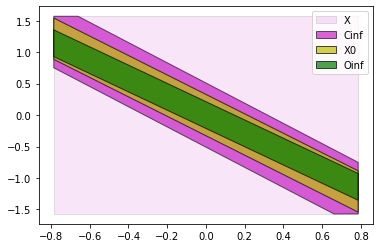

In [ ]:
# Plotting and Comparison
plt.clf()
plt.cla()
plt.close('all')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

X.plot(ax, color='m', alpha=0.1, linestyle='solid', linewidth=1, edgecolor=None)      # state constraint set
C_inf.plot(ax, color='m', alpha=0.6, linestyle='solid', linewidth=1)    # maximal control invariant set 
X0.plot(ax, color='y', alpha=0.7, linestyle='solid', linewidth=1)       # initial feasible set 
O_inf.plot(ax, color='g', alpha=0.7, linestyle='solid', linewidth=1)    # maximal positive invariant set 
ax.legend(['X', 'Cinf', 'X0', 'Oinf'])

ax.autoscale_view()
# ax.axis('equal')
plt.show()

***

# Simulation with MPC

Do the simulation of the above inverted pendulum system in closed-loop with MPC controller. Consider the MPC horizon as N=3, $\texttt{Q=eye(2)}$ and $\texttt{R=1}$, the terminal constraint as $\mathcal{O}_{\infty}$ and the terminal cost as $P_{\infty}$ computed by solving the Algebraic Riccatti Equation. The intitial condition is $x_0 = [-0.5, 1]^T$ and the simulation length is M=25. 

In [ ]:
# Setup the CFTOC

import pyomo.environ as pyo

Xf = O_inf
Af = Xf.A
bf = Xf.b
Q = np.eye(2)
R = np.array([1]).reshape(1,1)
P = Pinf
N = 3
x1U = np.pi/4
x2U = np.pi/2
uU = np.pi/10
x0 = np.array([-0.5, 1])
# x0 = np.array([0.5, 1.25])


def solve_cftoc(A, B, P, Q, R, N, x0, x1U, x2U, uL, uU, bf, Af):
    
    model = pyo.ConcreteModel()
    model.N = N
    model.nx = np.size(A, 0)
    model.nu = np.size(B, 1)
    model.nf = np.size(Af, 0)
    
    # length of finite optimization problem:
    model.tIDX = pyo.Set( initialize= range(model.N+1), ordered=True )  
    model.xIDX = pyo.Set( initialize= range(model.nx), ordered=True )
    model.uIDX = pyo.Set( initialize= range(model.nu), ordered=True )
    
    model.nfIDX = pyo.Set( initialize= range(model.nf), ordered=True )
    
    # these are 2d arrays:
    model.A = A
    model.B = B
    model.Q = Q
    model.P = P
    model.R = R
    model.Af = Af
    model.bf = bf
    
    # Create state and input variables trajectory:
    model.x = pyo.Var(model.xIDX, model.tIDX)
    model.u = pyo.Var(model.uIDX, model.tIDX, bounds=(uL,uU))
    
    #Objective:
    def objective_rule(model):
        costX = 0.0
        costU = 0.0
        costTerminal = 0.0
        for t in model.tIDX:
            for i in model.xIDX:
                for j in model.xIDX:
                    if t < model.N:
                        costX += model.x[i, t] * model.Q[i, j] * model.x[j, t] 
        for t in model.tIDX:
            for i in model.uIDX:
                for j in model.uIDX:
                    if t < model.N:
                        costU += model.u[i, t] * model.R[i, j] * model.u[j, t]
        for i in model.xIDX:
            for j in model.xIDX:               
                costTerminal += model.x[i, model.N] * model.P[i, j] * model.x[j, model.N]
        return costX + costU + costTerminal
    
    model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)
    
    # Constraints:
    def equality_const_rule(model, i, t):
        return model.x[i, t+1] - (sum(model.A[i, j] * model.x[j, t] for j in model.xIDX)
                               +  sum(model.B[i, j] * model.u[j, t] for j in model.uIDX) ) == 0.0 if t < model.N else pyo.Constraint.Skip
    

    model.equality_constraints = pyo.Constraint(model.xIDX, model.tIDX, rule=equality_const_rule)
    model.init_const1 = pyo.Constraint(expr = model.x[0, 0] == x0[0])
    model.init_const2 = pyo.Constraint(expr = model.x[1, 0] == x0[1])
    model.state_limit1 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[0, t] <= x1U
                                   if t < N else pyo.Constraint.Skip)
    model.state_limit2 = pyo.Constraint(model.tIDX, rule=lambda model, t: -x1U <= model.x[0, t]
                                    if t < N else pyo.Constraint.Skip)
    model.state_limit3 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[1, t] <= x2U
                                   if t < N else pyo.Constraint.Skip)
    model.state_limit4 = pyo.Constraint(model.tIDX, rule=lambda model, t: -x2U <= model.x[1, t]
                                    if t < N else pyo.Constraint.Skip)
    
    def final_const_rule(model, i):
        return sum(model.Af[i, j] * model.x[j, model.N] for j in model.xIDX) <= model.bf[i] 
    
    model.final_const = pyo.Constraint(model.nfIDX, rule=final_const_rule)
    
    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)
    
    if str(results.solver.termination_condition) == "optimal":
        feas = True
    else:
        feas = False
            
    xOpt = np.asarray([[model.x[i,t]() for i in model.xIDX] for t in model.tIDX]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T
    
    JOpt = model.cost()
      
    return [model, feas, xOpt, uOpt, JOpt]

[model, feas, xOpt, uOpt, JOpt] = solve_cftoc(A, B, P, Q, R, N, x0, x1U, x2U, -uU, uU, bf, Af)

(-0.5243424427152101,
 0.011191297019413644,
 -0.03446075406539738,
 1.049260035907876)

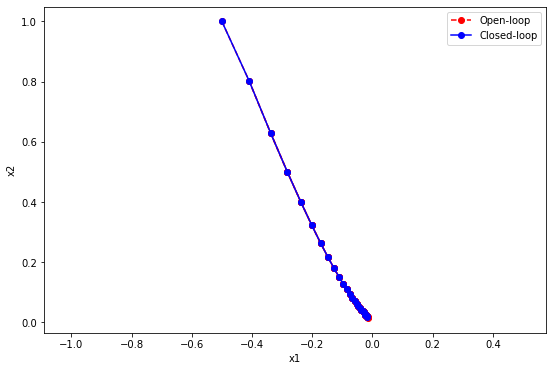

In [ ]:
# Setup the simulation with MPC controller

nx = np.size(A, 0)
nu = np.size(B, 1)

M = 25   # Simulation steps
xOpt = np.zeros((nx, M+1))
uOpt = np.zeros((nu, M))
xOpt[:, 0] = x0.reshape(nx, )

xPred = np.zeros((nx, N+1, M))
predErr = np.zeros((nx, M-N+1))

feas = np.zeros((M, ), dtype=bool)
xN = np.zeros((nx,1))

fig = plt.figure(figsize=(9, 6))
for t in range(M):
    [model, feas[t], x, u, J] = solve_cftoc(A, B, P, Q, R, N, xOpt[:, t], x1U, x2U, -uU, uU, bf, Af)
    
    if not feas[t]:
        xOpt = []
        uOpt = []
        predErr = []
        break
    # Save open loop predictions
    xPred[:, :, t] = x

    # Save closed loop trajectory
    # Note that the second column of x represents the optimal closed loop state
    xOpt[:, t+1] = x[:, 1]
    uOpt[:, t] = u[:, 0].reshape(nu, )

    # Plot Open Loop
    line1 = plt.plot(x[0,:], x[1,:], 'ro--')

# Plot Closed Loop
line2 = plt.plot(xOpt[0, :], xOpt[1, :], 'bo-')
plt.legend([line1[0], line2[0]], ['Open-loop', 'Closed-loop']);
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')

In [ ]:
# Plotting the polytopic sets and the closed loop trajectory 
plt.clf()
plt.cla()
plt.close('all')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

X.plot(ax, color='m', alpha=0.1, linestyle='solid', linewidth=1, edgecolor=None)      # state constraint set
C_inf.plot(ax, color='m', alpha=0.6, linestyle='solid', linewidth=1)    # maximal control invariant set 
X0.plot(ax, color='y', alpha=0.7, linestyle='solid', linewidth=1)       # initial feasible set 
O_inf.plot(ax, color='g', alpha=0.7, linestyle='solid', linewidth=1)    # maximal positive invariant set 
ax.legend(['X', 'Cinf', 'X0', 'Oinf'])

ax.plot(xOpt[0, :], xOpt[1, :], 'bo-', markerfacecolor='none', markeredgewidth=0.5, linewidth= 0.5, label='traj')  # closed loop trajectory 
ax.plot(xOpt[0, 0], xOpt[1, 0], 'ro', label='init') # the initial condition x0

ax.autoscale_view()
ax.axis('equal')
plt.show()